© 2025 Zitao Yang, Rebecca J. Rousseau, Sara Mahdavi, Hernan G. Garcia, and Rob Phillips, *The dynamics of inducible genetic circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Dynamics of mutual repression

In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import math
import param
from scipy.signal import find_peaks
import scipy.optimize
from sympy import *

# Figure formatting

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True           # use LaTeX rendering for plot text
plt.rcParams['mathtext.fontset'] = 'stix'    # math font size
plt.rcParams['font.family'] = 'STIXGeneral'  # font style
plt.rcParams['axes.labelpad'] = 8.0

In [3]:
def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ probability of repressor/activator being active
    
    Parameters:
        - C: inducer concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

## Mutual repression: model and function definitions

In [5]:
def evolveMutualRepression(Rs, y, r1, r2, w1, w2, k, p1, p2, delt):
    
    R1, R2 = Rs
    dRdt = np.zeros_like(Rs)
    dRdt[0] = -y*R1 + r1/(1 + 2*(p2*R2) + w1*(p2*R2)**2)
    dRdt[1] = -R2 + r2/(1 + 2*(p1*R1/k) + w2*(p1*R1/k)**2)

    Rs_new = Rs + dRdt * delt
    
    return Rs_new

def steadyStateMutualRepression(y, r1, r2, w1, w2, k, p1, p2):

    coeff = np.array([p1**4*w2**2/k**4,
                      4*p1**3*w2/k**3 - p1**4*r1*w2**2/k**4/y,
                      4*p1**2/k**2 + 2*p1**2*w2/k**2 - 4*p1**3*r1*w2/k**3/y + 2*p1**2*p2*r2*w2/k**2,
                      4*p1/k - 4*p1**2*r1/k**2/y - 2*p1**2*r1*w2/k**2/y + 4*p1*p2*r2/k,
                      1 - 4*p1*r1/k/y + p2**2*r2**2*w1 +2*p2*r2,
                      -r1/y])
    
    return np.roots(coeff)

def R2MutualRepression(R1s, y, r1, r2, w1, w2, k, p1s):

    R2s = r2/(1 + 2*(p1s*R1s/k) + w2*(p1s*R1s/k)**2)

    return R2s

def dr1_dt(R1, R2, y, r1, r2, w1, w2, k, p1, p2):
    return -y*R1 + r1/(1 + 2*(p2*R2) + w1*(p2*R2)**2)

def dr2_dt(R1, R2, y, r1, r2, w1, w2, k, p1, p2):
    return -R2 + r2/(1 + 2*(p1*R1/k) + w2*(p1*R1/k)**2)

# Determine stability from the Jacobian
def Jacob(R1, R2, y, r1, r2, w1, w2, k, p1, p2):
    f1R1 = (-1)*y
    f1R2 = (-1)*r1*((2*p2)+2*w1*(p2**2)*R2)/((1 + 2*(p2*R2) + w1*(p2*R2)**2)**2)
    f2R1 = (-1)*r2*(2*(p1/k)+2*w2*((p1/k)**2)*R1)/((1 + 2*(p1*R1/k) + w2*(p1*R1/k)**2)**2)
    f2R2 = -1
    return np.array([[f1R1, f1R2],[f2R1, f2R2]])

## Single inducer

In [7]:
# Generate bifurcation diagram when tuning ONE INDUCER (here, regulating activity of repressor R1)

nstep = 10**(2)
delt = 10**(-2)
ts = np.linspace(0, nstep*delt, nstep+1)

length = 100
Cs = np.logspace(-7, -4, length)
p_acts = pAct(Cs)

Cxs = 10**((-1)*7 + (3*ts))
pxs = pAct(Cxs)
pys = 1

y, r1, r2, w1, w2, k = 1, 2, 2, 7.5, 7.5, 1

R1s = []
stabR1 = []
unstabR1 = []
stabR2 = []
unstabR2 = []
positive_Cs_stable = []
positive_Cs_unstable = []
tsstab = []
tsunstab = []

for i in range(len(p_acts)):
    R1s = steadyStateMutualRepression(y, r1, r2, w1, w2, k, p_acts[i],pys)
    real_Rs = np.real(R1s[np.isreal(R1s)])
    fixed_pointsA = real_Rs[real_Rs >= 0]

    P1s = p_acts[i]*np.ones(len(fixed_pointsA));
    fixed_pointsB = R2MutualRepression(fixed_pointsA, y, r1, r2, w1, w2, k, P1s)
    
    # Evaluate stability
    stab = np.zeros(len(fixed_pointsA))
    for j in range(len(fixed_pointsA)):
        RR1 = fixed_pointsA[j]
        RR2 = fixed_pointsB[j]
        w,v = np.linalg.eig(Jacob(R1=RR1, R2=RR2, y=y, r1=r1, r2=r2, w1=w1, w2=w2, k=k, p1=p_acts[i],p2=pys))
        evalsign = np.sign(w)
        if np.isreal(RR1) == True and np.isreal(RR2) == True and RR1 >= 0 and RR2 >= 0:
            if np.sum(evalsign) == -2:
                stabR1.append(RR1) # stable
                stabR2.append(RR2)
                positive_Cs_stable.append(Cs[i])
                tsstab.append(Cs[i])
            elif np.sum(evalsign) == 0:
                unstabR1.append(RR1) # unstable
                unstabR2.append(RR2)
                positive_Cs_unstable.append(Cs[i])
                tsunstab.append(Cs[i])

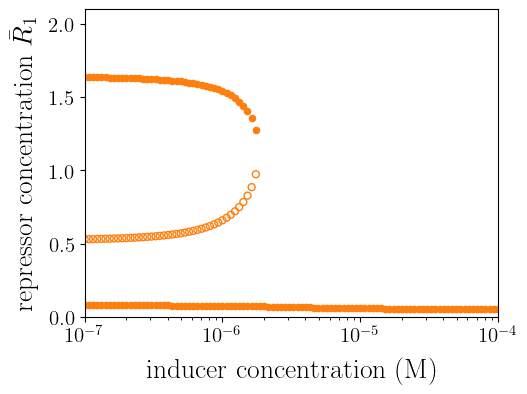

In [9]:
# Plot bifurcation diagram tracking specifically the R1 coordinate for steady states

fig, axs = plt.subplots(1, 1, figsize=(5.33333333,4))

axs.scatter(tsstab, stabR1, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange')
axs.scatter(tsunstab, unstabR1, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')

axs.set_xlabel(r"inducer concentration (M)")
axs.set_ylabel(r"repressor concentration $\bar{R}_{1}$")
axs.set_xlim(10**(-7), 10**(-4))
axs.set_ylim(0,2.1)
plt.xscale("log")
#plt.savefig('mutrep_bifurcationdiagramR1_singleinducer.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

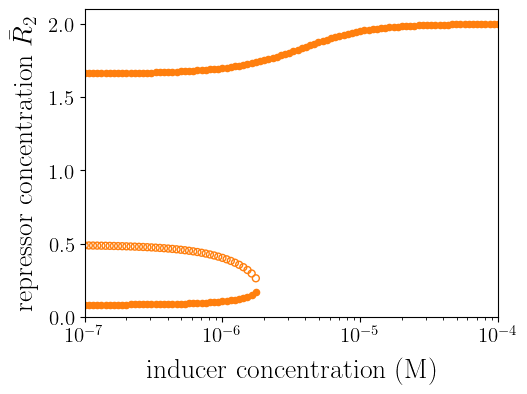

In [11]:
# Plot bifurcation diagram tracking specifically the R2 coordinate for steady states

fig, axs = plt.subplots(1, 1, figsize=(5.33333333,4))

axs.scatter(tsstab, stabR2, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange')
axs.scatter(tsunstab, unstabR2, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')

axs.set_xlabel(r"inducer concentration (M)")
axs.set_ylabel(r"repressor concentration $\bar{R}_{2}$")
axs.set_xlim(10**(-7), 10**(-4))
axs.set_ylim(0,2.1)
plt.xscale("log")
#plt.savefig('mutrep_bifurcationdiagramR2_singleinducer.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

Text(-0.01, 0.5, '$\\bar{R}_{2}$')

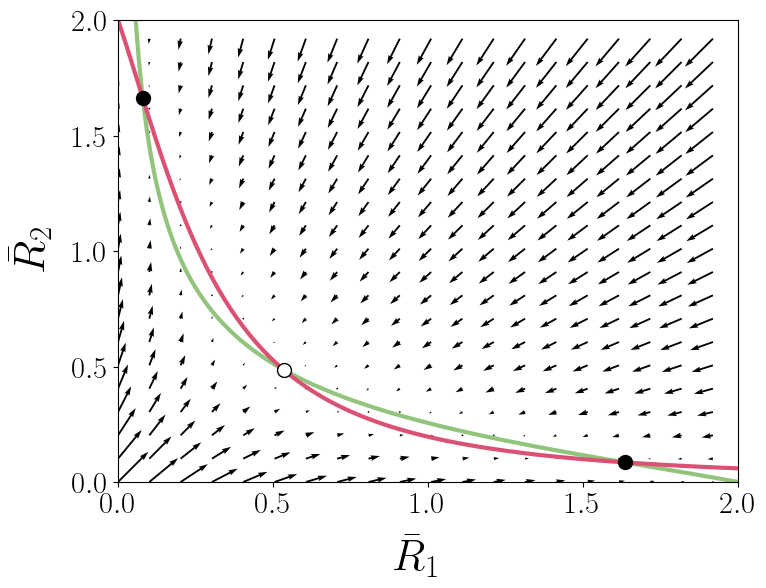

In [13]:
# Phase portrait with nullclines at low inducer concentration

tslice = [5]

# Create a grid of points
r1grid = np.linspace(0, 2, 100)
r2grid = np.linspace(0, 2, 100)
X, Y = np.meshgrid(r1grid, r2grid)

fig, ax = plt.subplots(1,len(tslice), figsize=(8, 6))

Rs = []

for j in range(len(tslice)):
    # Calculate fixed points
    ind = tslice[j]
    Rs = steadyStateMutualRepression(y, r1, r2, w1, w2, k, pxs[ind], pys)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    fixed_pointsA = real_Rs[real_Rs >= 0]
    
    P1s = pxs[ind]*np.ones(len(fixed_pointsA));
    fixed_pointsB = R2MutualRepression(fixed_pointsA, y, r1, r2, w1, w2, k, P1s)

    # Evaluate stability
    stab = np.zeros(len(fixed_pointsA))
    for i in range(len(fixed_pointsA)):
        RR1 = fixed_pointsA[i]
        RR2 = fixed_pointsB[i]
        w,v = np.linalg.eig(Jacob(R1=RR1, R2=RR2, y=y, r1=r1, r2=r2, w1=w1, w2=w2, k=k, p1=pxs[ind], p2=pys))
        evalsign = np.sign(w)
        if np.sum(evalsign) == -2:
            stab[i] = 1
        elif np.sum(evalsign) == 0:
            stab[i] = -1

    # Calculate the derivatives at each point
    DX = dr1_dt(X, Y, y, r1, r2, w1, w2, k, pxs[ind], pys)
    DY = dr2_dt(X, Y, y, r1, r2, w1, w2, k, pxs[ind], pys)
    
    # Plot the nullclines
    ax.contour(X, Y, DX, levels=[0], colors="#93c47d",linewidths=3) #, label='x-nullcline') #"#1f77b4"
    ax.contour(X, Y, DY, levels=[0], colors="#db5174",linewidths=3) #, label='y-nullcline') #"#ff7f0e" "#aa2212"
    for w in range(len(fixed_pointsA)):
        if stab[w]==1:
            ax.plot(fixed_pointsA[w], fixed_pointsB[w], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black')
        elif stab[w]==-1:
            ax.plot(fixed_pointsA[w], fixed_pointsB[w], 'o', markersize=10, markerfacecolor='white', markeredgecolor='black')
    ax.quiver(X[::5,::5], Y[::5,::5], DX[::5,::5], DY[::5,::5])
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)

fig.supxlabel(r'$\bar{R}_{1}$', y=-0.05, fontsize=32)
fig.supylabel(r'$\bar{R}_{2}$', x=-0.01, fontsize=32)
#plt.savefig('mutrep_phaseportraitlowind_singleinducer.pdf', format='pdf', transparent='True', bbox_inches="tight")

Text(-0.01, 0.5, '$\\bar{R}_{2}$')

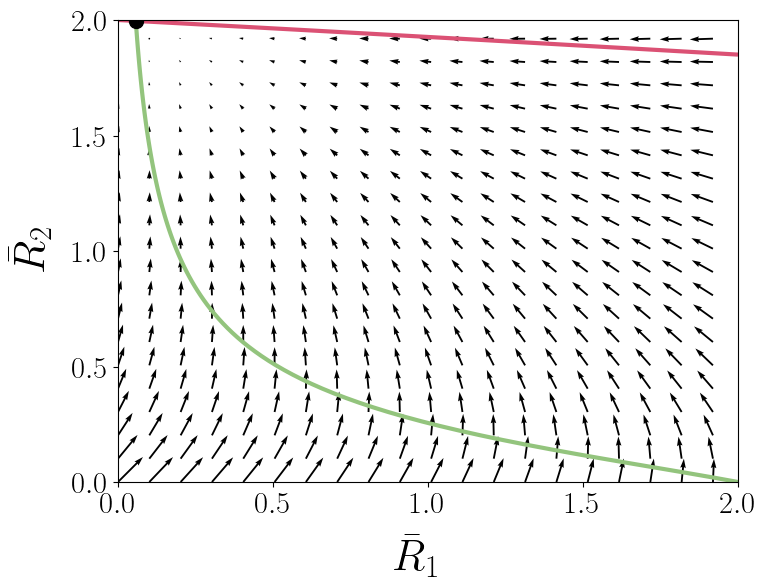

In [15]:
# Phase portrait with nullclines at high inducer concentration

tslice = [90]

# Create a grid of points
r1grid = np.linspace(0, 2, 100)
r2grid = np.linspace(0, 2, 100)
X, Y = np.meshgrid(r1grid, r2grid)

fig, ax = plt.subplots(1,len(tslice), figsize=(8, 6))

Rs = []

for j in range(len(tslice)):
    # Calculate fixed points
    ind = tslice[j]
    Rs = steadyStateMutualRepression(y, r1, r2, w1, w2, k, pxs[ind], pys)
    real_Rs = np.real(Rs[np.isreal(Rs)])
    fixed_pointsA = real_Rs[real_Rs >= 0]
    
    P1s = pxs[ind]*np.ones(len(fixed_pointsA));
    fixed_pointsB = R2MutualRepression(fixed_pointsA, y, r1, r2, w1, w2, k, P1s)
    
    # Evaluate stability
    stab = np.zeros(len(fixed_pointsA))
    for i in range(len(fixed_pointsA)):
        RR1 = fixed_pointsA[i]
        RR2 = fixed_pointsB[i]
        w,v = np.linalg.eig(Jacob(R1=RR1, R2=RR2, y=y, r1=r1, r2=r2, w1=w1, w2=w2, k=k, p1=pxs[ind], p2=pys))
        evalsign = np.sign(w)
        if np.sum(evalsign) == -2:
            stab[i] = 1
        elif np.sum(evalsign) == 0:
            stab[i] = -1

    # Calculate the derivatives at each point
    DX = dr1_dt(X, Y, y, r1, r2, w1, w2, k, pxs[ind], pys)
    DY = dr2_dt(X, Y, y, r1, r2, w1, w2, k, pxs[ind], pys)
    
    # Plot the nullclines
    ax.contour(X, Y, DX, levels=[0], colors="#93c47d",linewidths=3) #, label='x-nullcline') #"#1f77b4"
    ax.contour(X, Y, DY, levels=[0], colors="#db5174",linewidths=3) #, label='y-nullcline') #"#ff7f0e" "#aa2212"
    for w in range(len(fixed_pointsA)):
        if stab[w]==1:
            ax.plot(fixed_pointsA[w], fixed_pointsB[w], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black')
        elif stab[w]==-1:
            ax.plot(fixed_pointsA[w], fixed_pointsB[w], 'o', markersize=10, markerfacecolor='white', markeredgecolor='black')
    ax.quiver(X[::5,::5], Y[::5,::5], DX[::5,::5], DY[::5,::5])
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)

fig.supxlabel(r'$\bar{R}_{1}$', y=-0.05, fontsize=32)
fig.supylabel(r'$\bar{R}_{2}$', x=-0.01, fontsize=32)
#plt.savefig('mutrep_phaseportraithighind_singleinducer.pdf', format='pdf', transparent='True', bbox_inches="tight")

## Two inducers

0
100
200
300
400


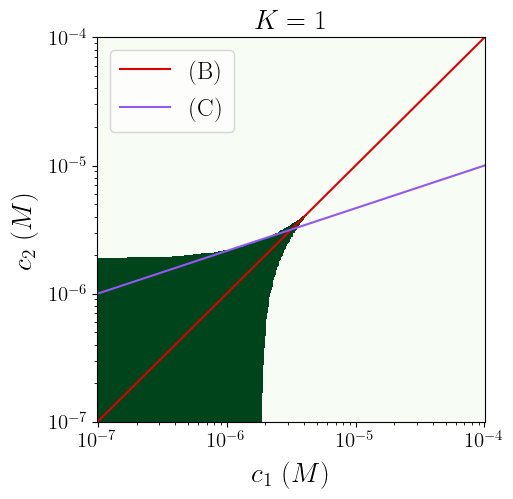

In [17]:
# Plot phase diagram in (c1, c2) inducer space for K = 1, distinguishing bistable from monostable parameter space

length = 500

C1s = np.logspace(-7, -4, length)
p_act1s = pAct(C1s)

C2s = np.logspace(-7, -4, length)
p_act2s = pAct(C2s)

C2sp = np.logspace(-6, -5, length)
y, r1, r2, w1, w2, k = 1, 2, 2, 7.5, 7.5, 1

C1, C2 = np.meshgrid(C1s, C2s)
P1, P2 = np.meshgrid(p_act1s, p_act2s)
hysteresis = np.zeros_like(P1)

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(length):
    if i%100 == 0:
        print(i)
    for j in range(length):
        sol = steadyStateMutualRepression(y, r1, r2, w1, w2, k, P1[i, j], P2[i, j])
        hysteresis[i, j] = np.count_nonzero(np.isreal(sol))


ax.pcolormesh(C1, C2, hysteresis, cmap="Greens", rasterized=True)
ax.plot(C1s, C2s, label=r"(B)", c="#dd0000")
ax.plot(C1s, C2sp, label=r"(C)", c="#9158f4")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$c_1$ $(M)$")
ax.set_ylabel(r"$c_2$ $(M)$")
plt.title(rf"$K = {k}$")
plt.legend(loc='upper left')
#plt.savefig('mutrep_phase diagram_K_1_w1_75_w2_75_r1_2_r2_2.pdf', format='pdf', transparent='True', bbox_inches='tight')
plt.show()

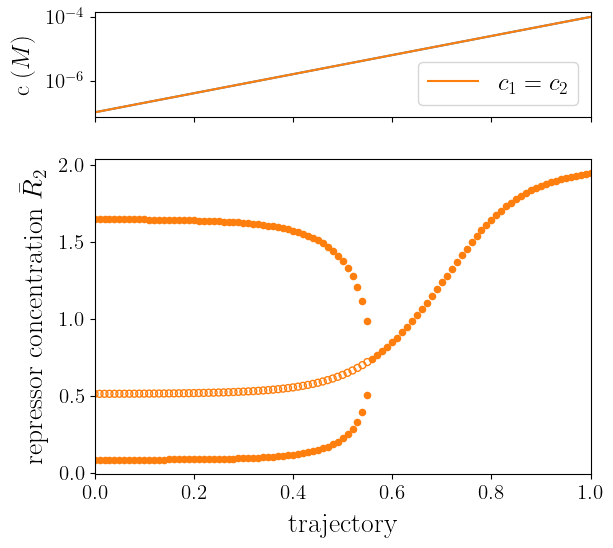

In [19]:
# Bifurcation diagram for system in which both inducer concentrations increase in time at the same rate
# The trajectory here follows the red path (B) from low to high inducer concentrations in the phase diagram above

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

length = 1000
Csrep = np.logspace(-7, -4, length)
cexprange = np.linspace(-7, -4, length)
p_acts = pAct(Csrep)

nstep = 10**(2)
delt = 10**(-2)
ts = np.linspace(0, nstep*delt, nstep+1)

Cxs = 10**((-1)*7 + (3*ts))
Cys = 10**((-1)*7 + (3*ts))
#Cys = 10**(-6+ts)
pxs = pAct(Cxs)
pys = pAct(Cys)

y, r1, r2, w1, w2, k = 1, 2, 2, 7.5, 7.5, 1

R1s = []
stabR1 = []
unstabR1 = []
stabR2 = []
unstabR2 = []
positive_Cs_stable = []
positive_Cs_unstable = []
tsstab = []
tsunstab = []

for i in range(len(pxs)):
    R1s = steadyStateMutualRepression(y, r1, r2, w1, w2, k, pxs[i],pys[i])
    real_Rs = np.real(R1s[np.isreal(R1s)])
    fixed_pointsA = real_Rs[real_Rs >= 0]

    P1s = pxs[i]*np.ones(len(fixed_pointsA));
    fixed_pointsB = R2MutualRepression(fixed_pointsA, y, r1, r2, w1, w2, k, P1s)
    
    # Evaluate stability
    stab = np.zeros(len(fixed_pointsA))
    for j in range(len(fixed_pointsA)):
        RR1 = fixed_pointsA[j]
        RR2 = fixed_pointsB[j]
        w,v = np.linalg.eig(Jacob(R1=RR1, R2=RR2, y=y, r1=r1, r2=r2, w1=w1, w2=w2, k=k, p1=pxs[i],p2=pys[i]))
        evalsign = np.sign(w)
        if np.isreal(RR1) == True and np.isreal(RR2) == True and RR1 >= 0 and RR2 >= 0:
            if np.sum(evalsign) == -2:
                stabR1.append(RR1) # stable
                stabR2.append(RR2)
                positive_Cs_stable.append(Cxs[i])
                tsstab.append(ts[i])
            elif np.sum(evalsign) == 0:
                unstabR1.append(RR1) # unstable
                unstabR2.append(RR2)
                positive_Cs_unstable.append(Cxs[i])
                tsunstab.append(ts[i])

axs[0].plot(ts, Cxs)
axs[0].plot(ts, Cys, label=r"$c_1 = c_2$")
axs[0].set_ylabel(r"c $(M)$", fontsize=18)
axs[0].set_yscale('log')
axs[0].legend(loc = 'lower right')
axs[0].xaxis.set_ticklabels([])
axs[0].set_xlim([min(ts), max(ts)])

axs[1].scatter(tsstab, stabR1, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange')
axs[1].scatter(tsunstab, unstabR1, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')

axs[1].set_xlabel(r"trajectory")
axs[1].set_ylabel(r"repressor concentration $\bar{R}_{2}$")
axs[1].set_xlim([0, 1])
#plt.savefig('mutrep_bifurcationdiagram.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

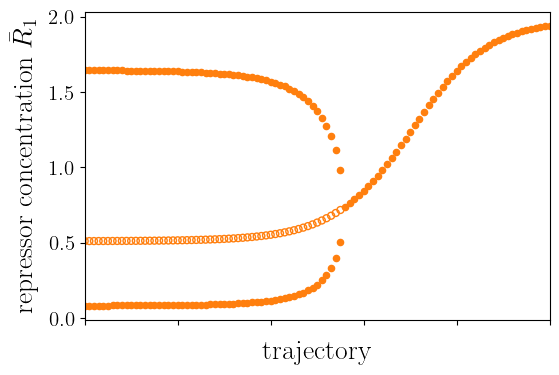

In [21]:
# Plot bifurcation diagram tracking specifically the R1 coordinate for steady states

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.xaxis.set_ticklabels([])

ax.scatter(tsstab, stabR1, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange')
ax.scatter(tsunstab, unstabR1, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')
ax.set_ylabel(r"repressor concentration $\bar{R}_{1}$")
ax.set_xlabel(r"trajectory")
ax.set_xlim([0, 1])
#plt.savefig('mutrep_bifurcationdiagram1_c1c2eq.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

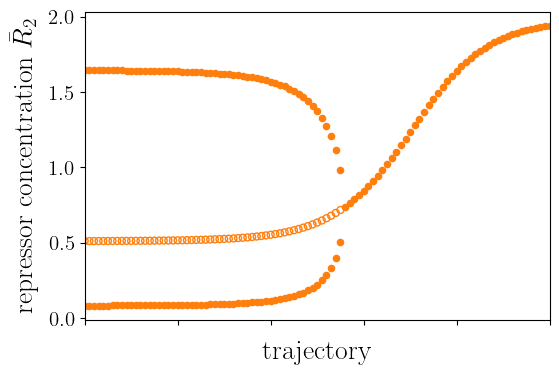

In [23]:
# Plot bifurcation diagram tracking specifically the R2 coordinate for steady states

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.xaxis.set_ticklabels([])

ax.scatter(tsstab, stabR2, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange')
ax.scatter(tsunstab, unstabR2, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')
ax.set_ylabel(r"repressor concentration $\bar{R}_{2}$")
ax.set_xlabel(r"trajectory")
ax.set_xlim([0, 1])
#plt.savefig('mutrep_bifurcationdiagram2_c1c2eq.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

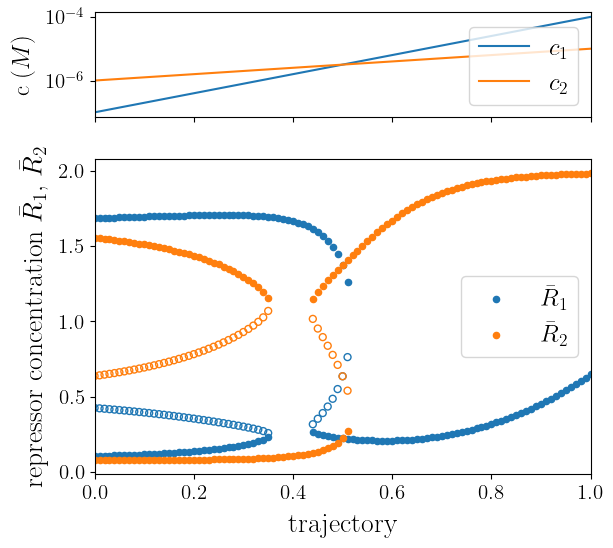

In [25]:
# Bifurcation diagram for system in which each inducer concentration increases at a different rate
# The trajectory here follows the purple path (C) from low to high inducer concentrations in the phase diagram

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

nstep = 10**(2)
delt = 10**(-2)
ts = np.linspace(0, nstep*delt, nstep+1)

Cxs = 10**((-1)*7 + (3*ts))
Cys = 10**(-6+ts)
pxs = pAct(Cxs)
pys = pAct(Cys)

y, r1, r2, w1, w2, k = 1, 2, 2, 7.5, 7.5, 1

R1s = []
stabR1 = []
unstabR1 = []
stabR2 = []
unstabR2 = []
positive_Cs_stable = []
positive_Cs_unstable = []
tsstab = []
tsunstab = []

for i in range(len(pxs)):
    R1s = steadyStateMutualRepression(y, r1, r2, w1, w2, k, pxs[i],pys[i])
    real_Rs = np.real(R1s[np.isreal(R1s)])
    fixed_pointsA = real_Rs[real_Rs >= 0]

    P1s = pxs[i]*np.ones(len(fixed_pointsA));
    fixed_pointsB = R2MutualRepression(fixed_pointsA, y, r1, r2, w1, w2, k, P1s)

    # Evaluate stability
    stab = np.zeros(len(fixed_pointsA))
    for j in range(len(fixed_pointsA)):
        RR1 = fixed_pointsA[j]
        RR2 = fixed_pointsB[j]
        w,v = np.linalg.eig(Jacob(R1=RR1, R2=RR2, y=y, r1=r1, r2=r2, w1=w1, w2=w2, k=k, p1=pxs[i],p2=pys[i]))
        evalsign = np.sign(w)
        if np.isreal(RR1) == True and np.isreal(RR2) == True and RR1 >= 0 and RR2 >= 0:
            if np.sum(evalsign) == -2:
                stabR1.append(RR1) # stable
                stabR2.append(RR2)
                positive_Cs_stable.append(Cxs[i])
                tsstab.append(ts[i])
            elif np.sum(evalsign) == 0:
                unstabR1.append(RR1) # unstable
                unstabR2.append(RR2)
                positive_Cs_unstable.append(Cxs[i])
                tsunstab.append(ts[i])

axs[0].plot(ts, Cxs, label=r'$c_1$')
axs[0].plot(ts, Cys, label=r'$c_2$')
axs[0].set_ylabel(r"c $(M)$", fontsize=18)
axs[0].set_yscale('log')
axs[0].legend(loc='lower right')
axs[0].xaxis.set_ticklabels([])
axs[0].set_xlim([min(ts), max(ts)])

axs[1].scatter(tsstab, stabR1, s=20, marker='o', facecolors = 'tab:blue', edgecolors = 'tab:blue', label=r'$\bar{R}_{1}$')
axs[1].scatter(tsunstab, unstabR1, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:blue')
axs[1].scatter(tsstab, stabR2, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange', label=r'$\bar{R}_{2}$')
axs[1].scatter(tsunstab, unstabR2, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')
axs[1].set_xlabel(r"trajectory")
axs[1].set_ylabel(r"repressor concentration $\bar{R}_{1}$, $\bar{R}_{2}$")
axs[1].set_xlim([0, 1])
axs[1].legend()
#plt.savefig('mutrep_diffinduc_bifurcationdiagram_snapshots.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

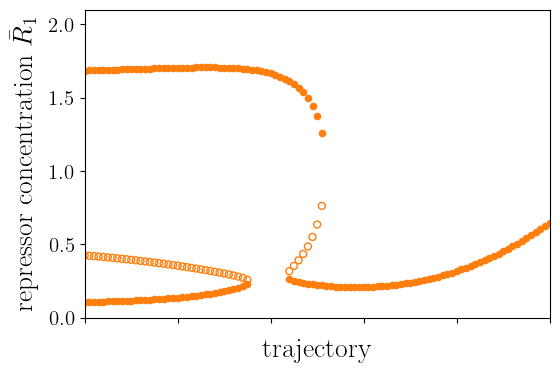

In [27]:
# Plot bifurcation diagram tracking specifically the R1 coordinate for steady states

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.xaxis.set_ticklabels([])

ax.scatter(tsstab, stabR1, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange')
ax.scatter(tsunstab, unstabR1, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')
ax.set_ylabel(r"repressor concentration $\bar{R}_{1}$")
ax.set_xlabel(r"trajectory")
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.1])
#plt.savefig('mutrep_bifurcationdiagram1_c1c2diff.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()

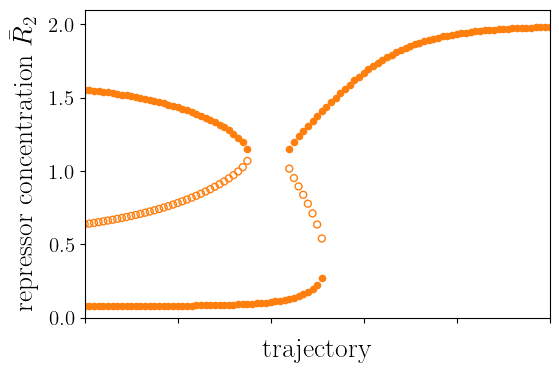

In [29]:
# Plot bifurcation diagram tracking specifically the R2 coordinate for steady states

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.xaxis.set_ticklabels([])

ax.scatter(tsstab, stabR2, s=20, marker='o', facecolors = 'tab:orange', edgecolors = 'tab:orange')
ax.scatter(tsunstab, unstabR2, s=25, marker='o', facecolors = 'none', edgecolors = 'tab:orange')
ax.set_ylabel(r"repressor concentration $\bar{R}_{2}$")
ax.set_xlabel(r"trajectory")
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.1])
#plt.savefig('mutrep_bifurcationdiagram2_c1c2diff.pdf', format='pdf', transparent='True', bbox_inches="tight")
plt.show()